In [1]:
%%capture
%pip install pandas_read_xml
%pip install tqdm   
%pip install pymupdf
%pip install numpy
%pip install nltk
%pip install tqdm

import pandas_read_xml as pdx
from pandas_read_xml import flatten, fully_flatten, auto_separate_tables, auto_flatten

import time
import os, sys
import re
import pandas as pd
import numpy as np
import nltk
import tqdm
import time
import gc
import concurrent.futures
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import multiprocessing
# from google.colab import drive

# drive.mount('/content/drive')

## Parsing answers of users from SE (Software Engineering)

In [702]:
def load_xml_as_pd_dict(root_folder, folder_names):
    dir_list = os.listdir(root_folder)
    print(dir_list)
    dir_list = [item for item in dir_list if item.split(".")[1] == "xml" if item.split(".")[0].lower() in folder_names]
    pandas_dict = {}
    for elem in dir_list:
        key = elem.split(".")[0]
        print(key)
        df = pdx.read_xml(os.path.join(root_folder, elem), [key.lower()])
        df = df.pipe(flatten)
        df = df.pipe(flatten)
        col_dict = { col_name : col_name.split("@")[1] for col_name in list(df.columns) }
        df = df.rename(columns=col_dict)
        pandas_dict[key.lower()] = df
    return pandas_dict


def display_post_df(posts: pd.core.frame.DataFrame, start, end) -> None:
    print(posts.loc[start:end, ['Id', 'CreationDate', 'PostTypeId', 'OwnerUserId']])


# returns the list of user ids of users which mention a tag in the about me
def get_user_df_by_tags_and_rep(users_df, reputation):
    return users_df.loc[(users_df['AboutMe'].str.contains(r'\bJAVA\b', flags=re.IGNORECASE, na=False)) & (users_df['Reputation'] > reputation)]


def display_users_df(users, start, end):
    print(users.loc[start:end, ['Id', 'Reputation', 'DisplayName']])

    

In [703]:
pd_user_posts_dict = load_xml_as_pd_dict("D:\Skola\Skola-ing\DP\data\StackExchange\SE", ['posts', 'users'])

['Badges.xml', 'Comments.xml', 'PostHistory.xml', 'PostLinks.xml', 'Posts.xml', 'Tags.xml', 'Users.xml', 'Votes.xml', 'Vzorove_data.txt']
Posts
Users


In [704]:
pd_user_posts_dict['posts'].columns

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'CreationDate', 'Score',
       'ViewCount', 'Body', 'OwnerUserId', 'LastEditorUserId', 'LastEditDate',
       'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount',
       'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate', 'ContentLicense',
       'ParentId', 'OwnerDisplayName', 'LastEditorDisplayName'],
      dtype='object')

In [705]:
pd_user_posts_dict['users'].columns

Index(['Id', 'Reputation', 'CreationDate', 'DisplayName', 'LastAccessDate',
       'WebsiteUrl', 'Location', 'AboutMe', 'Views', 'UpVotes', 'DownVotes',
       'AccountId', 'ProfileImageUrl'],
      dtype='object')

In [706]:
%%capture
pd_user_posts_dict['posts'].head()

In [707]:
%%capture
pd_user_posts_dict['users']

In [708]:
pd_user_posts_dict['users'] = pd_user_posts_dict['users'].drop(columns=['ProfileImageUrl', 'WebsiteUrl', 'LastAccessDate'])
pd_user_posts_dict['posts'] = pd_user_posts_dict['posts'].drop(columns=['LastEditorUserId', 'LastEditDate', 'LastActivityDate'])
pd_user_posts_dict['posts'] = pd_user_posts_dict['posts'].rename(columns={'Id': 'PostId'})

In [709]:
%%capture
pd_user_posts_dict['posts']

In [710]:
%%capture
pd_user_posts_dict['users']

In [711]:
pd_user_posts_dict['posts'].dtypes

PostId                   object
PostTypeId               object
AcceptedAnswerId         object
CreationDate             object
Score                    object
ViewCount                object
Body                     object
OwnerUserId              object
Title                    object
Tags                     object
AnswerCount              object
CommentCount             object
FavoriteCount            object
ClosedDate               object
CommunityOwnedDate       object
ContentLicense           object
ParentId                 object
OwnerDisplayName         object
LastEditorDisplayName    object
dtype: object

In [712]:
pd_user_posts_dict['users'].dtypes

Id              object
Reputation      object
CreationDate    object
DisplayName     object
Location        object
AboutMe         object
Views           object
UpVotes         object
DownVotes       object
AccountId       object
dtype: object

In [713]:
post_convert_dict = {'PostId': int,
                'PostTypeId': int,
                'AcceptedAnswerId': int,
                'Score': int,
                'ViewCount': int,
                'OwnerUserId': int,
                'AnswerCount': int,
                'CommentCount': int,
                'FavoriteCount': int,
                'ParentId': int,
                }

user_convert_dict = {'Id': int,
                'Reputation': int,
                'Views': int,
                'UpVotes': int,
                'DownVotes': int,
                'AccountId': int,
                }

pd_user_posts_dict['users'] = pd_user_posts_dict['users'].fillna(-1).astype(user_convert_dict)
pd_user_posts_dict['posts'] = pd_user_posts_dict['posts'].fillna(-1).astype(post_convert_dict)

In [714]:
pd_user_posts_dict['users']['AboutMe'].isnull().sum()

0

In [715]:
pd_user_posts_dict['users'] = pd_user_posts_dict['users'].sort_values(by="Reputation", ascending=False)

In [716]:
pd_whole_dict = pd_user_posts_dict.copy()

In [717]:
pd_user_posts_dict['users'] = get_user_df_by_tags_and_rep(pd_user_posts_dict['users'], 110)
pd_whole_dict['users'] = get_user_df_by_tags_and_rep(pd_whole_dict['users'], 100)

In [718]:
pd_user_posts_dict['users'][:10]

,Id,Reputation,CreationDate,DisplayName,Location,AboutMe,Views,UpVotes,DownVotes,AccountId
1156,1352,95315,2010-09-11T23:46:09.743,Jörg W Mittag,"Karlsruhe, Germany",<p>Not a software developer in the sense that ...,8856,499,14091,2172
11131,14221,45837,2011-01-24T09:11:22.457,Péter Török,"Turku, Finland",<p>Started programming around 1983 on ABC-80 a...,4293,2721,53,97818
2668,3249,42615,2010-09-21T16:25:12.203,Aaronaught,"Mountain View, CA",<p>Software engineer at Google. Not an enterpr...,3705,195,372,17239
52120,61852,38302,2012-08-14T21:18:50.363,Tulains Córdova,Spain,<blockquote>\n<p>I seek not to know all the an...,2313,2641,607,1748798
13277,16929,32984,2011-02-11T19:24:56.147,kevin cline,"Seattle, WA, USA",<p>I've been programming since I was 15. I st...,3697,2074,104,81527
1960,2314,27571,2010-09-16T20:55:49.863,Nicole,"Salt Lake City, UT, United States",<p>Full stack software engineer. I've mostly u...,4296,1386,180,48256
5757,7167,24282,2010-11-06T18:39:18.337,Gary Rowe,United Kingdom,<p>I'm a web developer working in the UK. I ha...,1621,2025,11,170199
535,611,21854,2010-09-09T11:46:40.187,Martijn Verburg,"London, United Kingdom","<p>(aka the ""Diabolical Developer""). I'm the ...",2165,561,20,166592
98230,121368,20110,2014-02-26T05:40:29.277,Aviv Cohn,Israel,<p>Passionate about C++ development and softwa...,1209,363,6,3773810
16134,20673,19596,2011-03-20T05:23:58.393,DXM,"Rochester, NY",<p>In my previous life I have always been a ba...,1308,571,45,208582


In [719]:
pd_user_posts_dict['posts']

,PostId,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense,ParentId,OwnerDisplayName,LastEditorDisplayName
0,1,1,13,2010-09-01T19:34:48.000,100,58142,<p>A coworker of mine believes that <em>any</e...,6,"""Comments are a code smell""",<comments><anti-patterns>,34,10,76,2012-11-27T20:11:51.580,2011-01-31T09:04:54.130,CC BY-SA 2.5,-1,-1,-1
1,3,2,-1,2010-09-01T19:36:50.053,29,-1,"<p>Ideally, code should be so well coded that ...",11,-1,-1,-1,17,-1,-1,2011-01-31T09:04:54.130,CC BY-SA 2.5,1,-1,-1
2,4,1,26,2010-09-01T19:37:39.957,66,9565,<p>When starting a project for a company that'...,-1,Getting non-programmers to understand the deve...,<business><project-management><development-pro...,12,2,34,-1,-1,CC BY-SA 2.5,-1,user8,user8
3,7,2,-1,2010-09-01T19:42:16.797,10,-1,"<p>I think the answer is the usual ""It depends...",21,-1,-1,-1,0,-1,-1,2011-01-31T09:04:54.130,CC BY-SA 2.5,1,-1,-1
4,9,1,-1,2010-09-01T19:43:04.957,39,13113,"<p>Sometimes, the things I have to do for my j...",17,How do you stay focused at work?,<productivity><time-management>,24,1,26,2012-11-13T19:09:35.853,2011-01-04T21:22:43.957,CC BY-SA 2.5,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232234,431658,2,-1,2021-09-04T21:15:21.363,1,-1,"<p>When building event driven systems, events ...",60357,-1,-1,-1,1,-1,-1,-1,CC BY-SA 4.0,431657,-1,-1
232235,431659,1,-1,2021-09-04T21:53:17.773,0,7,"<p>I am working on an application right now, w...",401491,Handling realtime notification receivers in a ...,<web><websockets><real-time><notifications>,0,0,-1,-1,-1,CC BY-SA 4.0,-1,-1,-1
232236,431660,1,-1,2021-09-04T22:35:19.087,0,19,<p>This is more of a design/architecture quest...,400361,Designing a logic to receive ACK for every mes...,<architecture><c><message-queue><embedded-syst...,0,0,-1,-1,-1,CC BY-SA 4.0,-1,-1,-1
232237,431661,2,-1,2021-09-04T23:55:02.070,1,-1,<p>To simply fix the issue at hand (data reten...,284628,-1,-1,-1,0,-1,-1,-1,CC BY-SA 4.0,431657,-1,-1


In [720]:
def count_q_a_by_user_id(post_df, user_id):
    return len(post_df.loc[(post_df['OwnerUserId'] == user_id) & (post_df['PostTypeId'] == 1)]), len(post_df.loc[(post_df['OwnerUserId'] == user_id) & (post_df['PostTypeId'] == 2)])



def get_user_ids_for_filtering(user_df, post_df):
    user_id_list = []
    for idx, user_row in user_df.iterrows():
        # print(user_row['Id'])
        user_q_count, user_a_count = count_q_a_by_user_id(post_df, user_row['Id'])
        if user_a_count >= 1:
            user_id_list.append(user_row['Id'])
    return user_id_list 

In [721]:
id_list = get_user_ids_for_filtering(pd_user_posts_dict['users'], pd_user_posts_dict['posts'])

In [722]:
len(id_list)

1227

In [723]:
id_list

[1352,
 14221,
 3249,
 61852,
 16929,
 2314,
 7167,
 611,
 121368,
 20673,
 1696,
 62323,
 5692,
 66,
 2366,
 2329,
 222996,
 12750,
 11107,
 11246,
 32008,
 193669,
 55314,
 17429,
 7080,
 232369,
 38223,
 257,
 114930,
 12061,
 86,
 88986,
 90992,
 28718,
 82764,
 7380,
 191975,
 1298,
 79793,
 90149,
 147,
 206652,
 8120,
 3790,
 1929,
 39690,
 20757,
 99,
 12402,
 25,
 5148,
 5433,
 79256,
 44767,
 98712,
 4316,
 70298,
 121951,
 4422,
 109112,
 7860,
 1177,
 21218,
 1788,
 103266,
 40724,
 1476,
 139925,
 14294,
 195918,
 5149,
 36596,
 3915,
 4688,
 81568,
 4662,
 44124,
 5024,
 8500,
 61509,
 76809,
 59134,
 2294,
 53263,
 38234,
 193,
 433,
 4603,
 100346,
 2671,
 13719,
 121080,
 27540,
 8458,
 12260,
 12135,
 3073,
 26988,
 23061,
 187465,
 71634,
 43527,
 40518,
 120,
 5487,
 55614,
 31101,
 19888,
 15090,
 23010,
 27079,
 51531,
 22765,
 82539,
 133110,
 12230,
 2301,
 82,
 9274,
 8538,
 3566,
 62,
 7654,
 13519,
 99407,
 18139,
 7567,
 270721,
 2554,
 471,
 3922,
 36966,
 

In [724]:
id_list[0]

1352

In [725]:
pd_user_posts_dict['users'] = pd_user_posts_dict['users'].loc[pd_user_posts_dict['users']['Id'].isin(id_list)]

In [726]:
pd_user_posts_dict['users'] = pd_user_posts_dict['users'].iloc[::13,:]
id_list = list(pd_user_posts_dict['users']['Id'])

In [727]:
pd_user_posts_dict['users']

,Id,Reputation,CreationDate,DisplayName,Location,AboutMe,Views,UpVotes,DownVotes,AccountId
1156,1352,95315,2010-09-11T23:46:09.743,Jörg W Mittag,"Karlsruhe, Germany",<p>Not a software developer in the sense that ...,8856,499,14091,2172
62,66,13048,2010-09-01T20:22:47.367,TheLQ,United States,<p>I write stuff</p>\n\n<p><strong>Languages:<...,1029,1582,140,137942
31290,38223,8397,2011-10-07T16:04:27.377,Madara's Ghost,Israel,<p>I have resigned and will no longer be avail...,1141,44,3,466356
72605,90149,4457,2013-05-05T12:58:49.073,BobDalgleish,-1,"<p>I am an experienced developer, in many lang...",331,290,82,1288640
63946,79256,3180,2013-01-23T11:25:22.697,RemcoGerlich,"Arnhem, Netherlands",<p>All-round software developer with 15 years ...,171,136,14,421112
...,...,...,...,...,...,...,...,...,...,...
44148,52807,111,2012-04-26T19:29:01.280,ianpojman,-1,<p>Java/Scala developer</p>\n,3,0,0,1416578
26848,33202,111,2011-08-02T18:19:11.177,easeout,United States,<p>I write Java servlets with SQL Server backe...,10,5,0,6477
268097,322212,111,2018-12-10T13:52:27.517,Jan Peter,"Groningen, Netherlands","<p>Web developer concentrating on AngularJS, A...",0,0,0,1145122
275983,331203,111,2019-03-18T02:01:51.040,rougou,-1,<p><strong>My Favorite...</strong></p>\n\n<ul>...,1,0,0,8609684


In [728]:
combined = pd_user_posts_dict['users'].merge(pd_user_posts_dict['posts'], left_on="Id", right_on="OwnerUserId")

In [729]:
combined

,Id,Reputation,CreationDate_x,DisplayName,Location,AboutMe,Views,UpVotes,DownVotes,AccountId,...,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense,ParentId,OwnerDisplayName,LastEditorDisplayName
0,1352,95315,2010-09-11T23:46:09.743,Jörg W Mittag,"Karlsruhe, Germany",<p>Not a software developer in the sense that ...,8856,499,14091,2172,...,-1,-1,2,-1,-1,2011-03-07T21:04:52.237,CC BY-SA 2.5,940,-1,-1
1,1352,95315,2010-09-11T23:46:09.743,Jörg W Mittag,"Karlsruhe, Germany",<p>Not a software developer in the sense that ...,8856,499,14091,2172,...,-1,-1,2,-1,-1,-1,CC BY-SA 2.5,10832,-1,-1
2,1352,95315,2010-09-11T23:46:09.743,Jörg W Mittag,"Karlsruhe, Germany",<p>Not a software developer in the sense that ...,8856,499,14091,2172,...,-1,-1,8,-1,-1,-1,CC BY-SA 2.5,18074,-1,-1
3,1352,95315,2010-09-11T23:46:09.743,Jörg W Mittag,"Karlsruhe, Germany",<p>Not a software developer in the sense that ...,8856,499,14091,2172,...,-1,-1,0,-1,-1,-1,CC BY-SA 2.5,19158,-1,-1
4,1352,95315,2010-09-11T23:46:09.743,Jörg W Mittag,"Karlsruhe, Germany",<p>Not a software developer in the sense that ...,8856,499,14091,2172,...,-1,-1,0,-1,-1,-1,CC BY-SA 2.5,19416,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,33202,111,2011-08-02T18:19:11.177,easeout,United States,<p>I write Java servlets with SQL Server backe...,10,5,0,6477,...,-1,-1,0,-1,-1,2011-09-09T13:40:37.633,CC BY-SA 2.5,106980,Kevin Conner,-1
1629,33202,111,2011-08-02T18:19:11.177,easeout,United States,<p>I write Java servlets with SQL Server backe...,10,5,0,6477,...,-1,-1,1,-1,-1,2011-09-09T13:40:37.633,CC BY-SA 2.5,106980,Kevin Conner,-1
1630,322212,111,2018-12-10T13:52:27.517,Jan Peter,"Groningen, Netherlands","<p>Web developer concentrating on AngularJS, A...",0,0,0,1145122,...,-1,-1,0,-1,-1,-1,CC BY-SA 4.0,366369,-1,-1
1631,331203,111,2019-03-18T02:01:51.040,rougou,-1,<p><strong>My Favorite...</strong></p>\n\n<ul>...,1,0,0,8609684,...,-1,-1,0,-1,-1,-1,CC BY-SA 4.0,386136,-1,-1


In [730]:
combined.loc[combined['Id'] == 1352].columns

Index(['Id', 'Reputation', 'CreationDate_x', 'DisplayName', 'Location',
       'AboutMe', 'Views', 'UpVotes', 'DownVotes', 'AccountId', 'PostId',
       'PostTypeId', 'AcceptedAnswerId', 'CreationDate_y', 'Score',
       'ViewCount', 'Body', 'OwnerUserId', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate',
       'ContentLicense', 'ParentId', 'OwnerDisplayName',
       'LastEditorDisplayName'],
      dtype='object')

In [731]:
sub_df_answers = combined.loc[combined['PostTypeId'] == 2, ['Id', 'PostId', 'Body']]

In [732]:
sub_df_answers.iloc[1]['Body']

'<p>There are two kinds of private code: private code that gets called by public code (or private code that gets called by private code that gets called by public code (or ...)) and private code that <em>does</em> not eventually get called by public code.</p>\n\n<p>The former already gets tested through the tests for the public code. The latter cannot be called <em>at all</em> and thus should be deleted, not tested.</p>\n\n<p>Note that when you do TDD it is impossible for untested private code to exist.</p>\n'

In [733]:
# !cp -r "drive/MyDrive/Colab Notebooks/python_modules/parsing_module/parsing" /content

In [734]:
from parsing import user_parsing, dep_parsing_module as dpm
from parsing.preprocessing import user_preprocessing

In [735]:
tags_pattern = re.compile(r"<.*?>")

In [736]:
# !rm -rf parsing

In [737]:
sub_df_answers['Body'] = sub_df_answers['Body'].apply(lambda x: re.sub(tags_pattern, "", x))

In [738]:
values_to_remove = [611, 1352, 2314, 3249, 4603, 11200, 14221, 3922, 19697, 24912]

In [739]:
custom_vals_to_remove = [val for val in values_to_remove if val in id_list]

print(custom_vals_to_remove)

# for val in values_to_remove:
#     print(val in id_list)

[1352, 3922, 19697, 24912]


In [740]:
def remove_val(given_list, value_list):
    # Traverse the value list
    for value in value_list:
       # using while loop to remove all occurrences of given value
        while(value in given_list):
            # removing the value using remove()
            given_list.remove(value)
           # return the list
    return given_list

In [741]:
custom_vals_to_remove

[1352, 3922, 19697, 24912]

In [742]:
24912 in id_list

True

In [743]:
id_list = remove_val(id_list, values_to_remove)

In [744]:
len(id_list)

91

In [745]:
body_txt = sub_df_answers.loc[sub_df_answers['Id'] == 36049]['Body']

In [746]:
print(body_txt)

Series([], Name: Body, dtype: object)


Setting paths to the dependency parser

In [747]:
dpm.jar_path = "D:/Skola/Skola-ing/DP/data/StackExchange/dependency_parser/stanford-corenlp-4.2.2/stanford-corenlp-4.2.2.jar"
dpm.models_jar_path = "D:/Skola/Skola-ing/DP/data/StackExchange/dependency_parser/stanford-corenlp-4.2.2-models-english.jar"

In [748]:
root_dir = "D:/Skola/Skola-ing/DP/data/parsed_data/acm_users/answers/userId"

def execute_user_parsing(dir_path, id_list, answer_df):
  for user_id in id_list:
      print(f"User id is : {user_id}")
      
      if not os.path.exists(dir_path + str(user_id)):
          os.mkdir(dir_path + str(user_id))
          time.sleep(5)
      
      # print(dir_path + str(user_id))

      local_user_df = answer_df.loc[answer_df['Id'] == user_id, ['PostId', 'Body']]

      print(f"Processing \"{len(local_user_df)}\" answers ...")

      local_dict = dict(zip(list(local_user_df['PostId'].astype(str)), list(local_user_df['Body'])))
      user_preprocessing.preproces_questions_into_tokens(local_dict)
      
      post_list = user_preprocessing.get_list_of_posts(local_dict)

      with multiprocessing.Pool(multiprocessing.cpu_count()) as exec:
        processes = []
        sub_post_list = [post_list[n:n+4] for n in range(0, len(post_list), 4)]
        for sub_post in tqdm.tqdm(sub_post_list):
            # args = [(local_dict[key], key, dpm.basic_pos_relations, dir_path + str(user_id)) for key in sub_post]
            # print(args[0])
            # exec.starmap(dpm.parse_section, args)
            for key in sub_post:
              dpm.parse_section(local_dict[key], key, dpm.basic_pos_relations, dir_path + str(user_id))
            #   # print(f"key is : {key}")
            #   # print(local_dict[key])
            #   # print(dpm.basic_pos_relations)
            #   # exec.submit(dpm.parse_section, *(local_dict[key], key, dpm.basic_pos_relations, dir_path + str(user_id)))  
            #   p = multiprocessing.Process(target=dpm.parse_section, args=[local_dict[key], key, dpm.basic_pos_relations, dir_path + str(user_id)]) 
            #   p.start()
            #   processes.append(p)
            # for process in processes:
            #     process.join()          
                          

In [749]:
# execute_user_parsing(root_dir, id_list[30:], sub_df_answers)

## Processing & parsing the accepted answers

In [750]:
pd_accepted_q = pd_whole_dict['posts'].loc[pd_whole_dict['posts']['AcceptedAnswerId'] >= 0].copy()
len(pd_accepted_q)

34661

In [751]:
pd_accepted_q

,PostId,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense,ParentId,OwnerDisplayName,LastEditorDisplayName
0,1,1,13,2010-09-01T19:34:48.000,100,58142,<p>A coworker of mine believes that <em>any</e...,6,"""Comments are a code smell""",<comments><anti-patterns>,34,10,76,2012-11-27T20:11:51.580,2011-01-31T09:04:54.130,CC BY-SA 2.5,-1,-1,-1
2,4,1,26,2010-09-01T19:37:39.957,66,9565,<p>When starting a project for a company that'...,-1,Getting non-programmers to understand the deve...,<business><project-management><development-pro...,12,2,34,-1,-1,CC BY-SA 2.5,-1,user8,user8
7,16,1,3675,2010-09-01T19:46:45.303,35,7372,<p>I have read a few articles on Internet abou...,18,Do dynamic typed languages deserve all the cri...,<programming-languages><dynamic-typing><static...,9,9,16,2013-02-20T21:50:27.170,-1,CC BY-SA 3.0,-1,-1,-1
8,18,1,25,2010-09-01T19:47:11.323,7,694,"<p>At first glance, I'd say a good programming...",9,Which (programming) specialities are needed in...,<team><web-development>,4,0,3,2013-08-02T14:29:15.503,-1,CC BY-SA 2.5,-1,-1,-1
14,38,1,54,2010-09-01T19:57:03.197,9,594,<p>Where waterfall commonly includes:</p>\n\n<...,9,How much effort should be put in each part of ...,<project-management><waterfall>,2,0,0,-1,-1,CC BY-SA 2.5,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232157,431559,1,431561,2021-09-01T01:22:37.640,17,2038,<p>Suppose I'm building a web application usin...,29231,How do you test and demonstrate that you have ...,<testing><multithreading><concurrency>,3,6,2,2021-09-01T17:49:20.140,-1,CC BY-SA 4.0,-1,-1,-1
232175,431579,1,431581,2021-09-01T19:24:09.113,0,78,<p>I've been running into a common pattern whe...,343245,How to combine data from multiple sources into...,<design><java><design-patterns><microservices>,1,1,-1,-1,-1,CC BY-SA 4.0,-1,-1,-1
232192,431604,1,431606,2021-09-02T20:48:00.167,2,93,<p>I have been assigned a ticket to update all...,396556,Is there merit to keeping packages/dependencie...,<node.js><dependencies><packages><legacy-code>,3,0,-1,-1,-1,CC BY-SA 4.0,-1,-1,-1
232195,431607,1,431609,2021-09-02T22:02:37.953,0,37,<p>I’m struggling a bit to design the followin...,374484,Design class with different dependency require...,<design><design-patterns><object-oriented-desi...,1,0,-1,-1,-1,CC BY-SA 4.0,-1,-1,-1


In [752]:
merged_accepted = pd_accepted_q.merge(pd_whole_dict['posts'], left_on="AcceptedAnswerId", right_on="PostId")
del pd_accepted_q
gc.collect()

81

In [753]:
merged_accepted.columns

Index(['PostId_x', 'PostTypeId_x', 'AcceptedAnswerId_x', 'CreationDate_x',
       'Score_x', 'ViewCount_x', 'Body_x', 'OwnerUserId_x', 'Title_x',
       'Tags_x', 'AnswerCount_x', 'CommentCount_x', 'FavoriteCount_x',
       'ClosedDate_x', 'CommunityOwnedDate_x', 'ContentLicense_x',
       'ParentId_x', 'OwnerDisplayName_x', 'LastEditorDisplayName_x',
       'PostId_y', 'PostTypeId_y', 'AcceptedAnswerId_y', 'CreationDate_y',
       'Score_y', 'ViewCount_y', 'Body_y', 'OwnerUserId_y', 'Title_y',
       'Tags_y', 'AnswerCount_y', 'CommentCount_y', 'FavoriteCount_y',
       'ClosedDate_y', 'CommunityOwnedDate_y', 'ContentLicense_y',
       'ParentId_y', 'OwnerDisplayName_y', 'LastEditorDisplayName_y'],
      dtype='object')

In [754]:
# check if the question is associated with java
def contains_java(df_row):
    return True if "<java>" in df_row['Tags_x'] or re.search(r'\bJAVA\b', df_row['Title_x'], flags=re.IGNORECASE) or re.search(r'\bJAVA\b', df_row['Body_x'], flags=re.IGNORECASE) else False
    

In [755]:
merged_accepted.loc[merged_accepted['PostTypeId_y'] == 2, ['Tags_x', 'PostId_y', 'Body_y', 'OwnerUserId_y', 'PostTypeId_y', 'Score_x']]

,Tags_x,PostId_y,Body_y,OwnerUserId_y,PostTypeId_y,Score_x
0,<comments><anti-patterns>,13,<p>Only if the comment describes what the code...,4,2,100
1,<business><project-management><development-pro...,26,<p>Pretty much everybody with a computer has e...,17,2,66
2,<programming-languages><dynamic-typing><static...,3675,"<p>Yes, I believe that they do.</p>\n\n<p>Ther...",148,2,35
3,<team><web-development>,25,<p>Customer (or an advocate of some sort). </...,21,2,7
4,<project-management><waterfall>,54,"<p>It depends on many factors, including:</p>\...",6,2,9
...,...,...,...,...,...,...
34656,<testing><multithreading><concurrency>,431561,<p>Sometimes you have some control over the ti...,3965,2,17
34657,<design><java><design-patterns><microservices>,431581,<p>The boilerplate code will probably look muc...,9113,2,0
34658,<node.js><dependencies><packages><legacy-code>,431606,<p>Updating a dependency generally grants you ...,40857,2,2
34659,<design><design-patterns><object-oriented-desi...,431609,<p>You've not abstracted this correctly.</p>\n...,106566,2,0


In [756]:
len(merged_accepted['PostId_y'].unique())

34661

In [757]:
sub_df_answers = merged_accepted.loc[merged_accepted['PostTypeId_y'] == 2, ['Tags_x', 'Title_x', 'Body_x', 'Score_x', 'PostId_y', 'Body_y', 'OwnerUserId_y', 'PostTypeId_y']]
sub_df_answers['refers_2_java'] = sub_df_answers.apply(lambda x: contains_java(x), axis=1)
sub_df_answers = sub_df_answers.sort_values(by="Score_x", ascending=False)
sub_df_answers = sub_df_answers.loc[sub_df_answers['refers_2_java'] == True, ['PostId_y', 'Body_y', 'Score_x', 'OwnerUserId_y']]
sub_df_answers['Body_y'] = sub_df_answers['Body_y'].apply(lambda x: re.sub(tags_pattern, "", x))

Extracting only accepted answers for the most valid questions

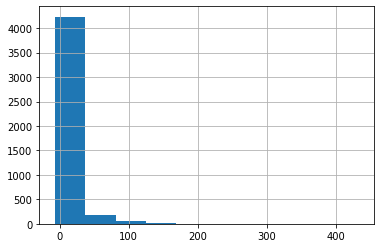

In [758]:
sub_df_answers['Score_x'].hist()

In [759]:
sub_df_answers['Score_x'].std()

23.973775770098378

In [760]:
sub_df_answers = sub_df_answers.loc[sub_df_answers['Score_x'] >= sub_df_answers['Score_x'].std()]

In [761]:
sub_df_answers

,PostId_y,Body_y,Score_x,OwnerUserId_y
14960,218394,In order to define what a service's responsibi...,433,3249
4805,102215,\n This is an old answer.\n See UTF-8 Everyw...,432,35174
4798,102118,Modern day startups need to hit the market as ...,391,10097
168,6303,"Sorry, this is going to be long, but it's base...",312,3340
633,18459,I prefer the second style. Get invalid cases ...,302,935
...,...,...,...,...
14836,215915,Note that IDEA has this inspection for Java as...,24,31260
11821,185643,"The general answer is no, because you should n...",24,11982
24853,329830,Very general philosophical reasoning\n\nTypica...,24,39877
349,11229,Cormen's Introduction to Algorithms is a good ...,24,2550


In [762]:
def execute_acc_ans_parsing(dir_path, start_idx, end_idx, answer_df):
  print(f"Processing \"{end_idx - start_idx}\" answers ...")
  
  if not os.path.exists(dir_path):
      os.mkdir(dir_path)
      time.sleep(5)
  
  # print(dir_path + str(user_id))

  local_user_df = answer_df.loc[:, ['PostId_y', 'Body_y']]
  # print(local_user_df)

  local_dict = dict(zip(list(local_user_df['PostId_y'].astype(str)), list(local_user_df['Body_y'])))
  user_preprocessing.preproces_questions_into_tokens(local_dict)
  
  post_list = user_preprocessing.get_list_of_posts(local_dict)

  for key in tqdm.tqdm(post_list[start_idx:end_idx]):
          dpm.parse_section(local_dict[key], key, dpm.basic_pos_relations, dir_path)


  # with multiprocessing.Pool(multiprocessing.cpu_count()) as exec:
  #   sub_post_list = [post_list[n:n+4] for n in range(0, len(post_list), 4)]
  #   for sub_post in tqdm.tqdm(sub_post_list):
        # args = [(local_dict[key], key, dpm.basic_pos_relations, dir_path) for key in sub_post]
        # print(args[0])
        # exec.starmap(dpm.parse_section, args)
        
        #   # print(f"key is : {key}")
        #   # print(local_dict[key])
        #   # print(dpm.basic_pos_relations)
        #   # exec.submit(dpm.parse_section, *(local_dict[key], key, dpm.basic_pos_relations, dir_path + str(user_id)))  
        #   p = multiprocessing.Process(target=dpm.parse_section, args=[local_dict[key], key, dpm.basic_pos_relations, dir_path + str(user_id)]) 
        #   p.start()
        #   processes.append(p)
        # for process in processes:
        #     process.join()          
                      

In [763]:
# execute_acc_ans_parsing("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers", 5, len(sub_df_answers), sub_df_answers)

## Model evaluation

### Loading the models

In [2]:
from parsing.model_evaluation import loading_models, metrics, ploting, model_processing_utils

In [3]:
# sections_book_dict = { name.split(".txt")[0] : loading_models.get_list_from_file(dir_path="D:\Skola\Skola-ing\DP\data\parsed_data\\acm_chapters", file_name=name) for name in os.listdir("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_chapters") } 
sections_book_dict = loading_models.get_list_from_file(dir_path="D:\Skola\Skola-ing\DP\data\parsed_data\\acm_chapters", "all")
user_dict = loading_models.get_user_dict_from_file(r"D:/Skola/Skola-ing/DP/data/parsed_data/acm_users/answers")
user_rep = loading_models.get_user_reputation_dict_from_file(r"D:\Skola\Skola-ing\DP\data\parsed_data\\acm_users\\reputation\user_reputation.txt")
# acc_ans_dict = { name.split(".txt")[0] : loading_models.get_list_from_file(dir_path="D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers", file_name=name) for name in os.listdir("D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers") } 
acc_ans_dict = loading_models.get_list_from_file(dir_path="D:\Skola\Skola-ing\DP\data\parsed_data\\acm_accepted_answers", 453)

100%|██████████| 1267/1267 [00:54<00:00, 23.21it/s]


In [4]:
print(f"num of user models: {len(user_dict)}, num of user reps: {len(user_rep)}")

num of user models: 95, num of user reps: 13085


### Basic model testing

Jaccard similarity

In [6]:
model_processing_utils.join_tuples_and_lemantize(user_dict)
model_processing_utils.join_tuples_and_lemantize(sections_book_dict)


In [7]:
merged_book = model_processing_utils.merge_models(sections_book_dict)

In [8]:
phrases_overal_jacq_sim = { key : metrics.jaccard_similarity(merged_book, user_dict[key]) for key in user_dict.keys()}

In [9]:
phrases_overal_jacq_sim['userId1352']

2.70076

In [10]:
present_user_rep = { key : user_rep[key.split('userId')[1]] for key in user_dict.keys()}
len(present_user_rep)

95

In [11]:
def calculate_order_score(dict1, dict2):
    our_reputation_sorted = dict(sorted(dict1.items(), key=lambda item: item[1]))
    user_reputation_sorted = dict(sorted(dict2.items(), key=lambda item: item[1]))

    right = 0
    wrong = 0

    print(our_reputation_sorted)
    print(user_reputation_sorted)

    for our_key, user_key in zip(our_reputation_sorted.keys(), user_reputation_sorted.keys()):
        if our_key == user_key:
            right += 1
        else:
            wrong += 1

    print("User on correct position: ", right)
    print("User on wrong position: ", wrong)

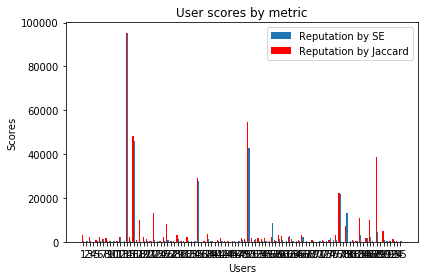

In [12]:
corr_coef = present_user_rep['userId1352']/phrases_overal_jacq_sim['userId1352']
scaled_user_rep = {key : present_user_rep[key]/corr_coef for key in present_user_rep}
scaled_jacc_rep = {key : int(phrases_overal_jacq_sim[key]*corr_coef) for key in phrases_overal_jacq_sim}
ploting.plot_vals(val_dict1=present_user_rep, val_dict2=scaled_jacc_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Jaccard")

C:\Users\kdeni\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


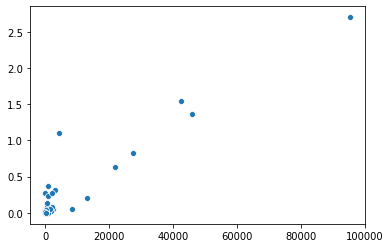

In [13]:
import seaborn as sb

# present_user_rep.pop("userId2314")
# phrases_overal_jacq_sim.pop("userId2314")

np_user_rep = np.array(list(present_user_rep.values()))
np_phrases_jacq_sim = np.array(list(phrases_overal_jacq_sim.values()))

# print(np_user_rep)
# print(np_phrases_jacq_sim)

sb.scatterplot(np_user_rep, np_phrases_jacq_sim)

In [14]:
my_rho = np.corrcoef(np_user_rep, np_phrases_jacq_sim)
print(my_rho)

[[1.        0.9444691]
 [0.9444691 1.       ]]


In [15]:
calculate_order_score(phrases_overal_jacq_sim, present_user_rep)

{'userId102854': 0.0, 'userId110891': 0.0, 'userId11912': 0.0, 'userId13234': 0.0, 'userId16363': 0.0, 'userId230189': 0.0, 'userId23127': 0.0, 'userId23989': 0.0, 'userId260000': 0.0, 'userId2960': 0.0, 'userId311114': 0.0, 'userId3766': 0.0, 'userId3937': 0.0, 'userId43607': 0.0, 'userId48295': 0.0, 'userId48538': 0.0, 'userId51052': 0.0, 'userId51329': 0.0, 'userId54786': 0.0, 'userId60361': 0.0, 'userId61822': 0.0, 'userId72086': 0.0, 'userId81711': 0.0, 'userId90621': 0.0, 'userId9915': 0.0, 'userId252775': 0.00978, 'userId956': 0.00978, 'userId24681': 0.00979, 'userId98956': 0.0098, 'userId11593': 0.00981, 'userId183841': 0.00981, 'userId74321': 0.00981, 'userId11937': 0.00982, 'userId1641': 0.00982, 'userId186153': 0.00982, 'userId215307': 0.00982, 'userId220929': 0.00982, 'userId28154': 0.00982, 'userId306735': 0.00982, 'userId89176': 0.00982, 'userId94922': 0.00982, 'userId157638': 0.00983, 'userId272442': 0.00983, 'userId45211': 0.0195, 'userId111157': 0.01958, 'userId51550':

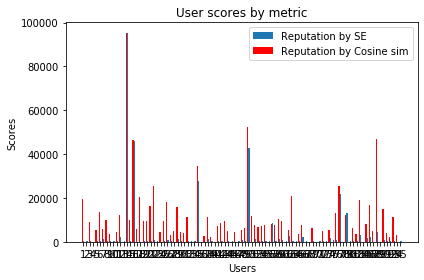

In [18]:
phrases_overal_cos_sim = metrics.get_cosine_sim(user_dict, merged_book)

corr_coef2 = present_user_rep['userId1352']/phrases_overal_cos_sim['userId1352']
scaled_user_rep2 = {key : present_user_rep[key]/corr_coef2 for key in present_user_rep}
scaled_cos_rep = {key : int(phrases_overal_cos_sim[key]*corr_coef2) for key in phrases_overal_cos_sim}
ploting.plot_vals(val_dict1=present_user_rep, val_dict2=scaled_cos_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Cosine sim")

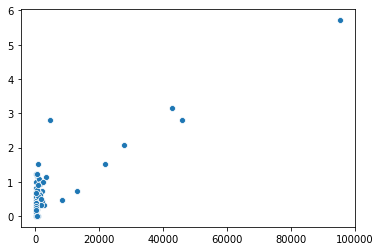

In [25]:
np_cos_sim = np.array(list(phrases_overal_cos_sim.values()))
sb.scatterplot(np_user_rep, np_cos_sim)

In [26]:
my_rho = np.corrcoef(np_user_rep, np_cos_sim)
print(my_rho)

[[1.         0.86021482]
 [0.86021482 1.        ]]


In [27]:
calculate_order_score(phrases_overal_cos_sim, present_user_rep)

User on correct position:  2
User on wrong position:  93


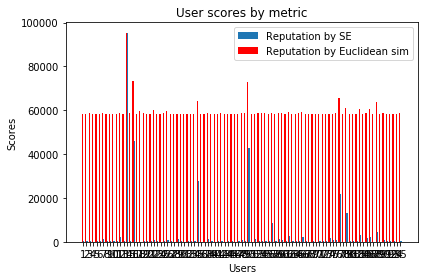

In [28]:
phrases_overal_euclid_sim = metrics.get_euclid_dis(user_dict, merged_book)

corr_coef3 = present_user_rep['userId1352']/phrases_overal_euclid_sim['userId1352']
scaled_user_rep3 = {key : present_user_rep[key]/corr_coef3 for key in present_user_rep}
scaled_euclid_rep = {key : int(phrases_overal_euclid_sim[key]*corr_coef3) for key in phrases_overal_euclid_sim}
ploting.plot_vals(val_dict1=present_user_rep, val_dict2=scaled_euclid_rep, metric_name1="Reputation by SE", metric_name2="Reputation by Euclidean sim")

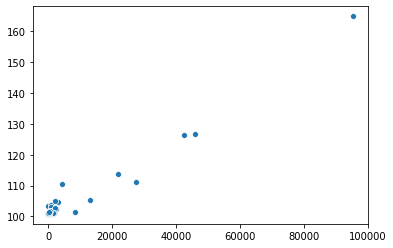

In [29]:
np_euclidean_sim = np.array(list(phrases_overal_euclid_sim.values()))

sb.scatterplot(np_user_rep, np_euclidean_sim)

In [30]:
my_rho = np.corrcoef(np_user_rep, np_euclidean_sim)
print(my_rho)

[[1.         0.98254456]
 [0.98254456 1.        ]]


In [31]:
calculate_order_score(phrases_overal_euclid_sim, present_user_rep)

User on correct position:  5
User on wrong position:  90


### Enriched model (accepted answers) testing

In [16]:
merged_answers = model_processing_utils.merge_models(acc_ans_dict)

In [19]:
len(merged_answers)

32609

In [20]:
len(merged_book)

10172

In [ ]:
merged_book = model_processing_utils.merge_into_existing_model(merged_book, merged_answers)